![alttext](../imgs/face_tiling.png)
<!-- <img src='https://github.com/levifussell/DeepSIM/blob/master/imgs/face_tiling.png'> -->

# DeepSIM Colab #

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/levifussell/DeepSIM/blob/master/notebooks/DeepSIM_colab_notebook.ipynb)

This notebook walks you through training DeepSIM on a custom dataset of my face. All credit of the source code goes to the original paper authors [here](https://github.com/eliahuhorwitz/DeepSIM). I just made some additions so the code was compatible with colab.

## Setup ##

In [1]:
#@title Setup

#@markdown Run this cell to download the code
#@markdown and build the training environment.

#@markdown After running it once, you'll need
#@markdown to restart the environment and run
#@markdown it a second time.

pull_repo = True

from IPython.utils import io
with io.capture_output() as captured:
  if pull_repo:
    %cd /content/
    %rm -rf DeepSIM || cd /content
    !git clone https://github.com/levifussell/DeepSIM
  %cd /content/DeepSIM
  # !perl -pi -e 's/torch==1\.8\.0//g' requirements.txt

  # !perl -pi -e 's/torch==1\.8\.0/torch==1\.8\.0+cu111/g' requirements.txt
  # !sed '22a\ --find-links https://download.pytorch.org/whl/torch_stable.html' requirements.txt

  !pip install torch==1.8.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
  !pip install -r requirements.txt
  !pip install imageio-ffmpeg


## Building your own dataset ## 

**If you already have a dataset, you can safely ignore this section.**

Here is a ffmpeg code snippet that will extract 'N' frames from your video. You can look through these frames to find the ones that would be best to animate over the top. Once you find a good image that is representative, include it in your own dataset directory as described below.

In [ ]:
#@title Building a dataset

%%capture

input_video_filename  = "datasets/face2/final_video.mp4"  #@param{type:"string"}
video_length_secs     = 27                                #@param{type:"integer"} 
sample_fps            = 1                                 #@param{type:"integer"}

import os
tmp_sample_dir = os.path.join('/content', 'DeepSIM', 'datasets', 'temp_samples')
os.makedirs(tmp_sample_dir, exist_ok=True)
tmp_frame_name = os.path.join(tmp_sample_dir, 'sample_frame%d.png')
range_info = f'between(t,{0},{video_length_secs})'
!ffmpeg -i '{input_video_filename}' -vf "fps='{sample_fps}',select='{range_info}'" -vsync 0 '{tmp_frame_name}' 

## Training ##

In [2]:
#@title Train Settings

#@markdown Enter the name of the directory where the
#@markdown data you want to use is. The directory should
#@markdown contain one folder for the real image(s),
#@markdown named "train_B", one folder for the,
#@markdown segmented image(s), named "train_seg", and
#@markdown one folder for the test image(s), name "test_seg".
#@markdown For example, here's what a dataset of an animation of your face
#@markdown might look like: <br><br>
#@markdown datasets/my_face/ <br>
#@markdown &ensp;|--- train_B/ <br>
#@markdown &ensp;|&emsp;|--- my_face_animation1.png <br>
#@markdown &ensp;|--- train_seg/ <br>
#@markdown &ensp;|&emsp;|--- my_face_photo1.png <br>
#@markdown &ensp;|--- test_seg/ <br>
#@markdown &ensp;|&emsp;|--- my_face_photo2.png <br>

data_directory  = "/content/DeepSIM/datasets/face2"  #@param{type:"string"}

#@markdown Give a name to tag the model and data with:

output_name     = "DeepSIMFace2"    #@param{type:"string"}

#@markdown Saving models to the mounted drive will avoid
#@markdown accidentally losing your progress if the runtime
#@markdown terminates:

save_to_drive   = True              #@param{type:"boolean"}

#@markdown augtmentation options:

tps_points_per_dim    = 3           #@param{type:"integer"}
use_cutmix_aug        = False       #@param{type:"boolean"}
use_affine_aug        = False       #@param{type:"boolean"}
use_canny_aug         = False       #@param{type:"boolean"}
use_recolor_aug       = False       #@param{type:"boolean"}

assert tps_points_per_dim > 0, "tps_points_per_dim must be a positive value."
use_cutmix_aug_value = int(use_cutmix_aug)
use_affine_aug_value = 'shearx_sheary_translationx_translationy_rotation' if use_affine_aug else 'none'
use_canny_aug_value = int(use_canny_aug)
use_recolor_aug_value = int(use_recolor_aug)

if save_to_drive:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


Train Data Output:


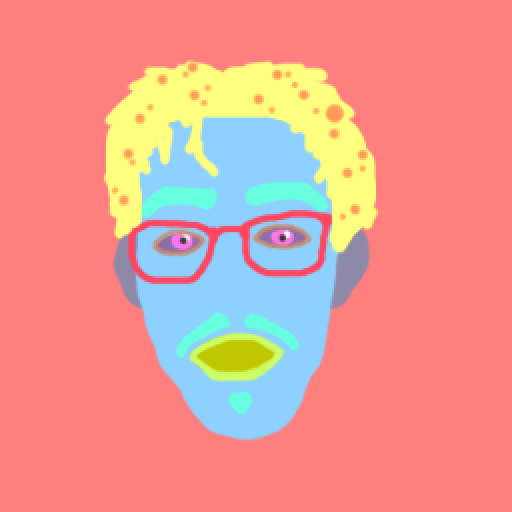

Train Data Input:


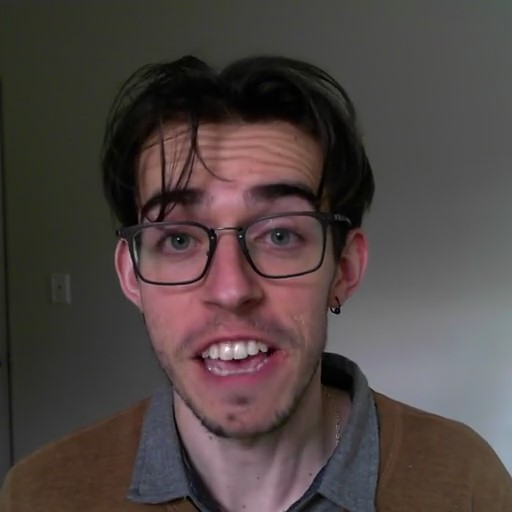

In [3]:
#@title Dataset Visualization

#@markdown Running this cell shows us
#@markdown what image we are going to
#@markdown be training on just to make
#@markdown sure.

from PIL import Image
from IPython.display import display
import os
import glob

print("Train Data Output:")
for f in glob.glob(os.path.join(data_directory, 'train_B', '*.png')):
  trainIm = Image.open(f)
  display(trainIm)
print("Train Data Input:")
for f in glob.glob(os.path.join(data_directory, 'train_seg', '*.png')):
  trainSeg = Image.open(f)
  display(trainSeg)

name DeepSIMFace2
GPU IDs [0]
CustomDatasetDataLoader
dataset [AlignedDataset] was created
#training images = 1
create web directory ./checkpoints/DeepSIMFace2/web...
display_delta 0
print_delta 0.0
save_delta 0


  1%|          | 200/16001 [02:19<3:05:42,  1.42it/s]

(epoch: 200, iters: 1, time: 0.698) G_GAN: 0.394 G_GAN_Feat: 1.913 D_real: 0.492 D_fake: 0.745 
input_label


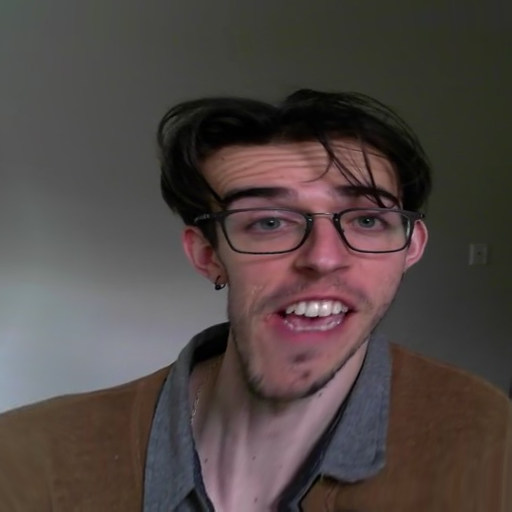

synthesized_image


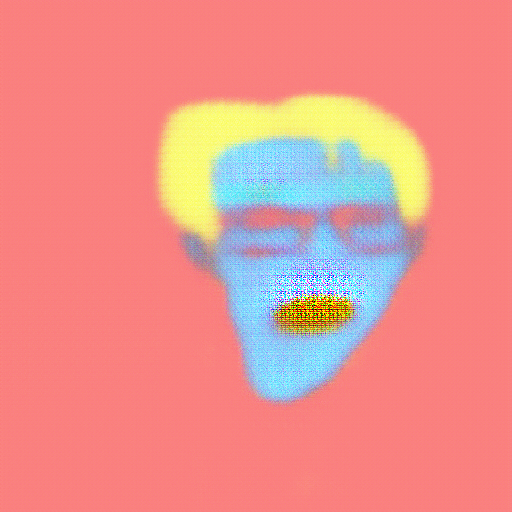

real_image


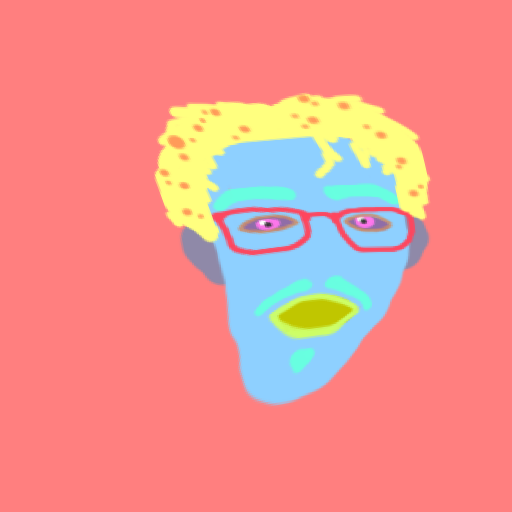

saving the latest model (epoch 200, total_steps 200)


  2%|▏         | 317/16001 [04:02<3:22:00,  1.29it/s]Exception ignored in: <function _releaseLock at 0x7f4a48fa98c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
  2%|▏         | 317/16001 [04:04<3:21:52,  1.29it/s]


KeyboardInterrupt: ignored

In [4]:
#@title Train Model

#@markdown <span style="color:red"><strong>IMPORTANT: if you are wanting to continue training from an old state, make sure to enable _'continue_train'_.</strong></span>

continue_train  = False             #@param{type:"boolean"}

#@markdown If you're happy with your settings above, all
#@markdown need to do is just run this cell now.

import train

notebook_args = {
    'name'                : output_name,
    'dataroot'            : data_directory,
    'primitive'           : 'seg',
    'no_instance'         : True,
    'tps_aug'             : 1,
    'tps_points_per_dim'  : tps_points_per_dim,
    'cutmix_aug'          : use_cutmix_aug_value,
    'affine_aug'          : use_affine_aug_value,
    'canny_aug'           : use_canny_aug_value,
    'recolor'             : use_recolor_aug_value,
    'no_vgg_loss'         : True,
    'gpu_ids'             : '0',
    'display_freq'        : 200,
    'save_latest_freq'    : 200,
    'print_freq'          : 200,
    'save_epoch_freq'     : 1000000,
    'batchSize'           : 1,
    'save_to_drive'       : save_to_drive,
    'continue_train'      : continue_train,

    # FIXED.
    'is_notebook' : True,
}

notebook_args['display_freq'] *= notebook_args['batchSize']
notebook_args['save_latest_freq'] *= notebook_args['batchSize']
notebook_args['save_epoch_freq'] *= notebook_args['batchSize']
notebook_args['print_freq'] *= notebook_args['batchSize']

train.run(notebook_args)

## Testing ##

rm: cannot remove '/content/DeepSIM/datasets/face2/test_seg/*.png': No such file or directory
rm: cannot remove '/content/DeepSIM/datasets/face2/test_B/*.png': No such file or directory
rm: cannot remove '/content/DeepSIM/datasets/face2/test_B/*.mp4': No such file or directory
name DeepSIMFace2
GPU IDs [0]
CustomDatasetDataLoader
dataset [AlignedDataset_test] was created
in initialize
dataset_size 6
torch.Size([1, 3, 512, 512]) torch.Size([1]) torch.Size([1]) torch.Size([1, 3, 512, 512])
['/content/DeepSIM/datasets/face2/test_seg/frame1.png']
process image... ['/content/DeepSIM/datasets/face2/test_seg/frame1.png']
label


/content/DeepSIM/models/pix2pixHD_model.py:136: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_label = Variable(input_label, volatile=infer)


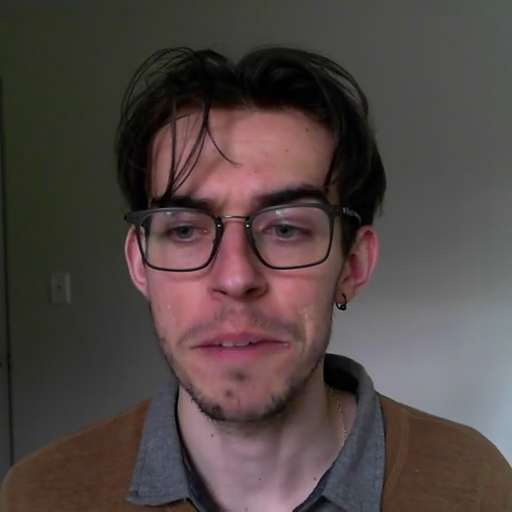

generated


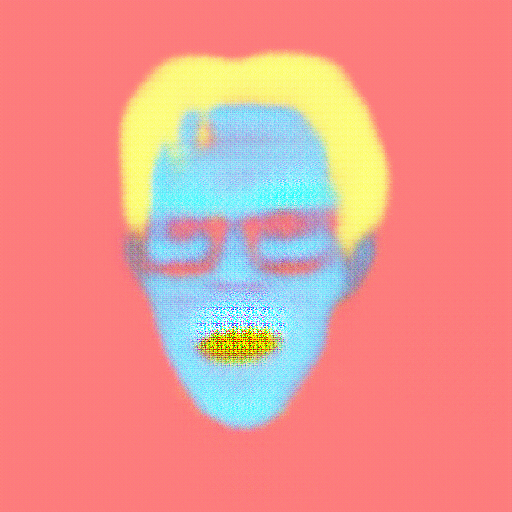

torch.Size([1, 3, 512, 512]) torch.Size([1]) torch.Size([1]) torch.Size([1, 3, 512, 512])
['/content/DeepSIM/datasets/face2/test_seg/frame2.png']
process image... ['/content/DeepSIM/datasets/face2/test_seg/frame2.png']
label


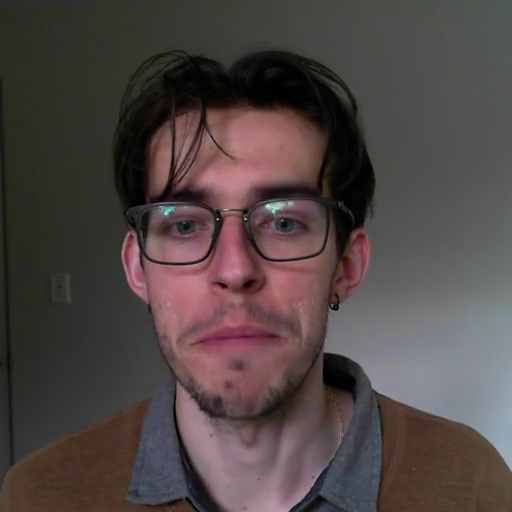

generated


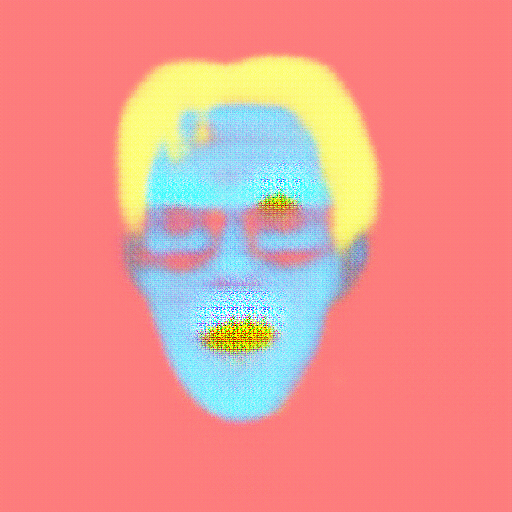

torch.Size([1, 3, 512, 512]) torch.Size([1]) torch.Size([1]) torch.Size([1, 3, 512, 512])
['/content/DeepSIM/datasets/face2/test_seg/frame3.png']
process image... ['/content/DeepSIM/datasets/face2/test_seg/frame3.png']
label


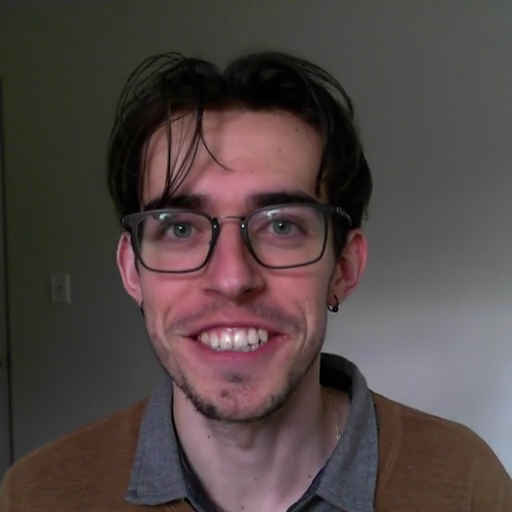

generated


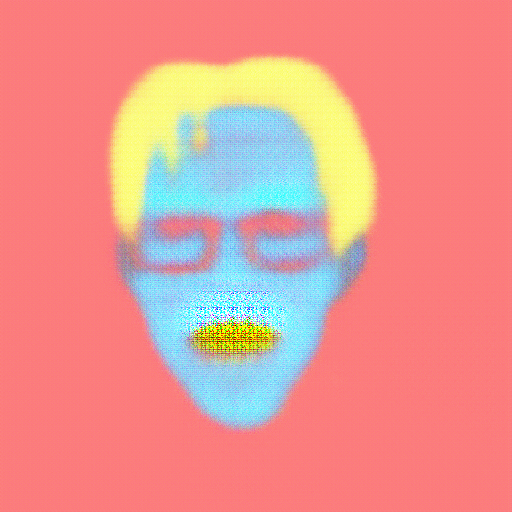

torch.Size([1, 3, 512, 512]) torch.Size([1]) torch.Size([1]) torch.Size([1, 3, 512, 512])
['/content/DeepSIM/datasets/face2/test_seg/frame4.png']
process image... ['/content/DeepSIM/datasets/face2/test_seg/frame4.png']
label


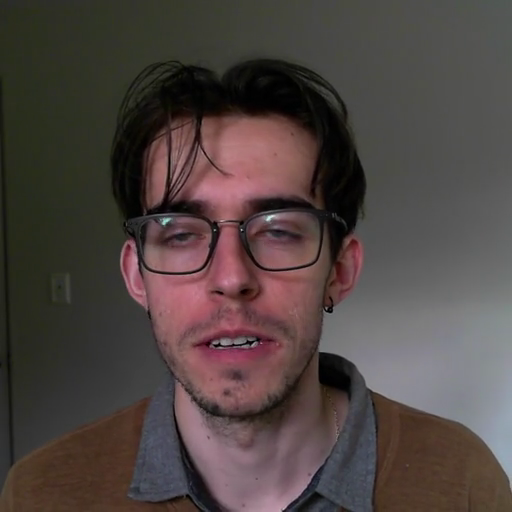

generated


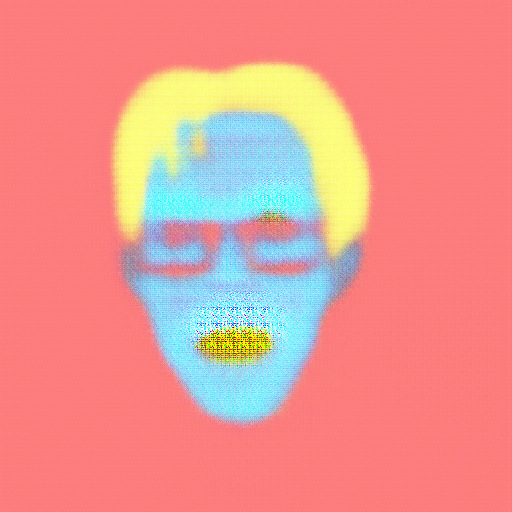

torch.Size([1, 3, 512, 512]) torch.Size([1]) torch.Size([1]) torch.Size([1, 3, 512, 512])
['/content/DeepSIM/datasets/face2/test_seg/frame5.png']
process image... ['/content/DeepSIM/datasets/face2/test_seg/frame5.png']
label


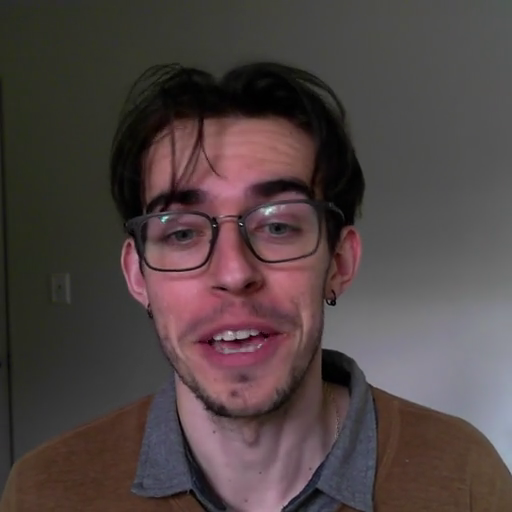

generated


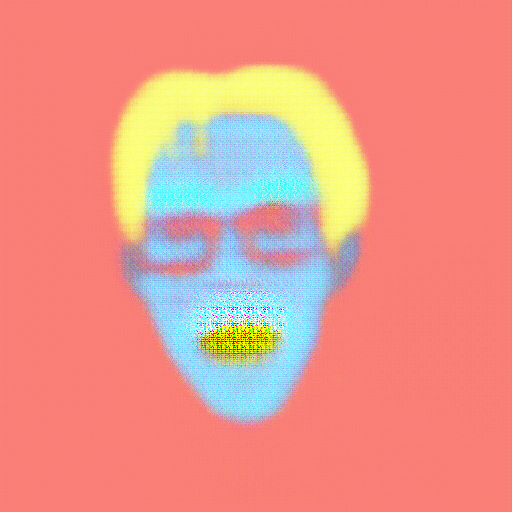

torch.Size([1, 3, 512, 512]) torch.Size([1]) torch.Size([1]) torch.Size([1, 3, 512, 512])
['/content/DeepSIM/datasets/face2/test_seg/frame6.png']
process image... ['/content/DeepSIM/datasets/face2/test_seg/frame6.png']
label


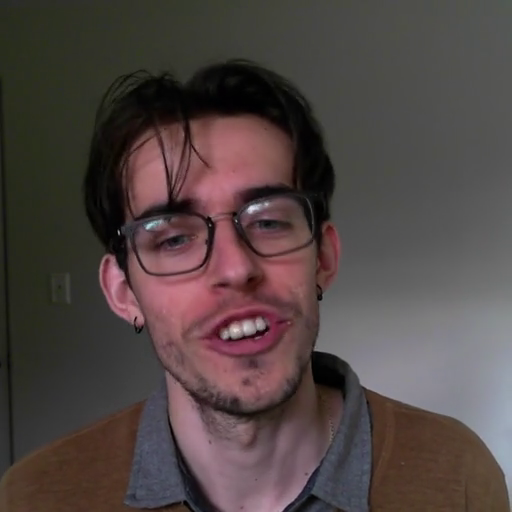

generated


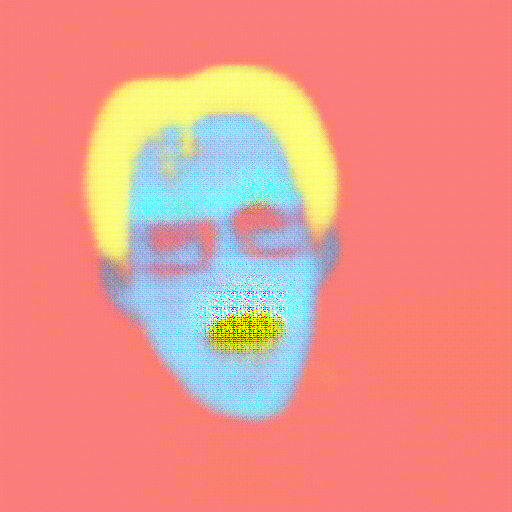

In [8]:
#@title Build Video Animation

#@markdown This cell will build your final video.
#@markdown Provide it with the filename of the video you want to build an animation from.
#@markdown <br>'video_fps' is the fps to sample the video you are animating _from_. The higher this value, the longer the generation time, but the higher the final quality.
#@markdown <br>'video_output_fps' is the fps of the animation video that will be _generated_. This is for compatibility with different video players.
video_filename    = "/content/DeepSIM/datasets/face2/me_talking_512.mp4"  #@param{type:"string"}
video_fps         = 10                                #@param{type:"integer"}
video_output_fps  = 30                                #@param{type:"integer"}

#@markdown 'test_mode' will only generate a few frames so you can see what the results will look like before you generate all the frames:
test_mode         = True                              #@param{type:"boolean"}

assert video_fps > 0, f"fps must be positive. You set it to {video_fps}"
assert video_output_fps > 0, f"output fps must be positive. You set it to {video_output_fps}"

import os
input_dir = os.path.join(data_directory, "test_seg")
os.makedirs(input_dir, exist_ok=True)
output_dir = os.path.join(data_directory, "test_B")
os.makedirs(output_dir, exist_ok=True)
frame_name = os.path.join(input_dir, "frame%d.png")

# extract frames from the video.

input_rm_path = os.path.join(input_dir, '*.png')
output_rm_path_imgs = os.path.join(output_dir, '*.png')
output_rm_path_video = os.path.join(output_dir, '*.mp4')
!rm {input_rm_path}
!rm {output_rm_path_imgs}
!rm {output_rm_path_video}

from IPython.utils import io
with io.capture_output() as captured:
  if test_mode:
    video_fps = 1
    !ffmpeg -i '{video_filename}' -vf "fps='{video_fps}',select='between(t,0,5)'" '{frame_name}'
  else:
    !ffmpeg -i '{video_filename}' -vf "fps='{video_fps}'" '{frame_name}'

# model inference on video frames.

import test
test.run({
    'name'                : output_name,
    'dataroot'            : data_directory,
    'primitive'           : 'seg',
    'no_instance'         : True,
    'which_epoch'         : 'latest',
    'save_to_drive'       : save_to_drive,

    # FIXED.
    'is_notebook'     : True,
    'phase'           : "test",
})

if not test_mode:
  
  # build animation video from generated frames.

  output_video_filename = os.path.join(output_dir, 'final_video.mp4')
  output_frame_name = os.path.join(output_dir, "frame%d.png")

  !ffmpeg -framerate '{video_fps}' -i '{output_frame_name}' -r '{video_output_fps}' -pix_fmt yuv420p '{output_video_filename}' 